Min/Max capacity  60 458
Mean proportion of arcs filled by the multi flow generation  0.3573200992555831
Mean/std proportion of flow in shortest paths  0.5893531354264896 0.004038034712511151
Median proportion of flow in shortest paths  0.5896553871600159
Size of heatmap  100 397
Size of heatmap  100 397
Minimal flow values range  13 31
Maximal flow values range  118 143
Heights histogram nodes in pairs {num_bin:val,...} 
{0: np.float64(0.2), 2: np.float64(0.3), 7: np.float64(0.3), 10: np.float64(0.1), 12: np.float64(0.1)}
Heights histogram flow passing through arcs {num_bin:val,...} 
{0: np.float64(0.22), 7: np.float64(0.187), 15: np.float64(0.259), 23: np.float64(0.173), 30: np.float64(0.065), 38: np.float64(0.063), 46: np.float64(0.017), 53: np.float64(0.009), 61: np.float64(0.003), 68: np.float64(0.003)}


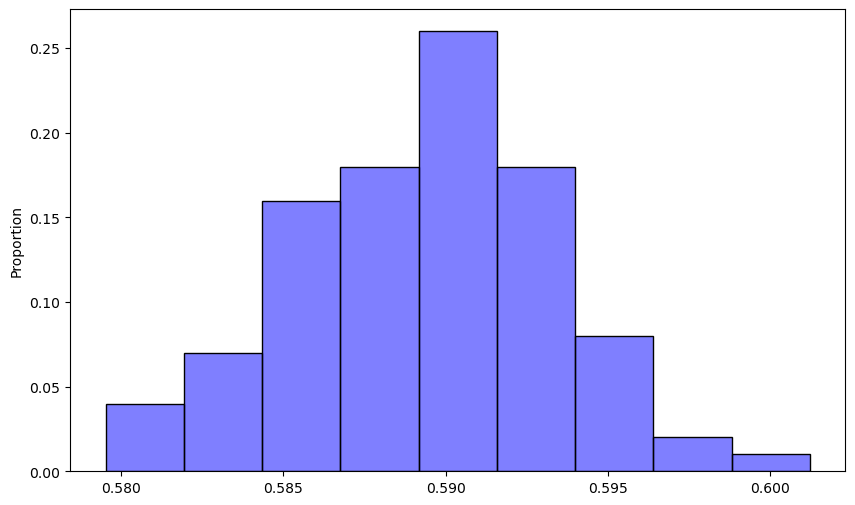

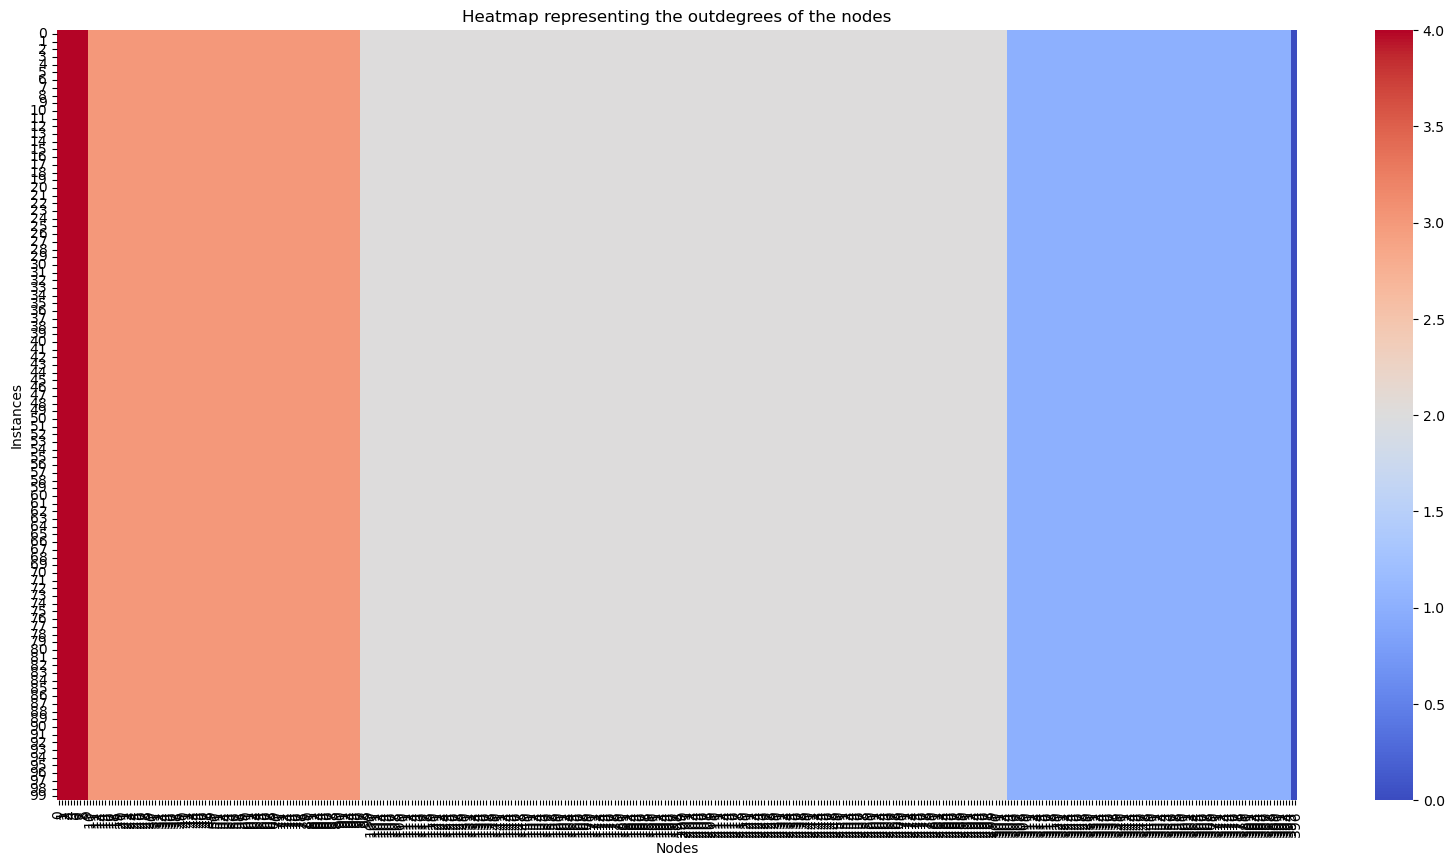

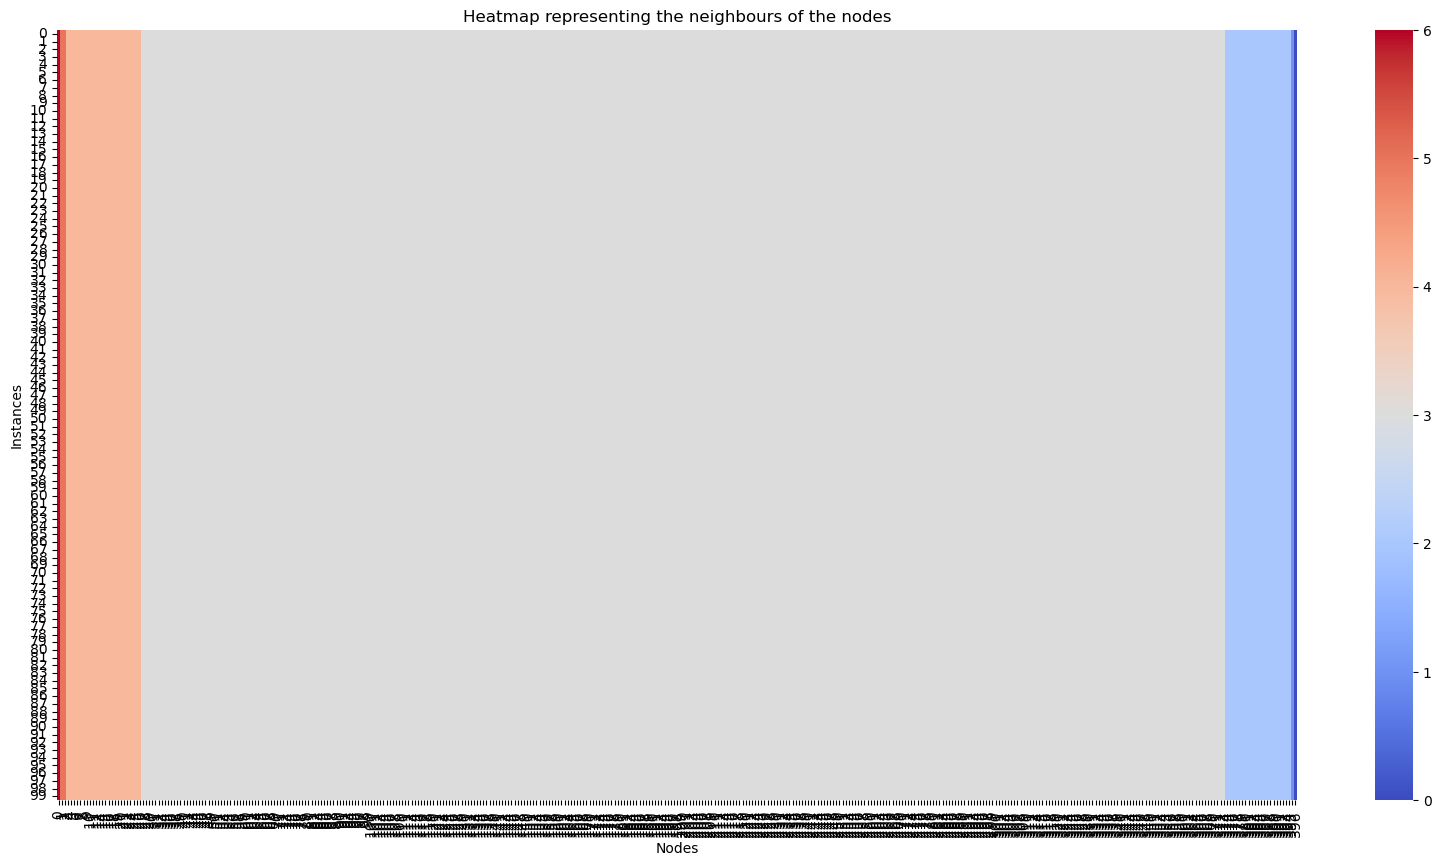

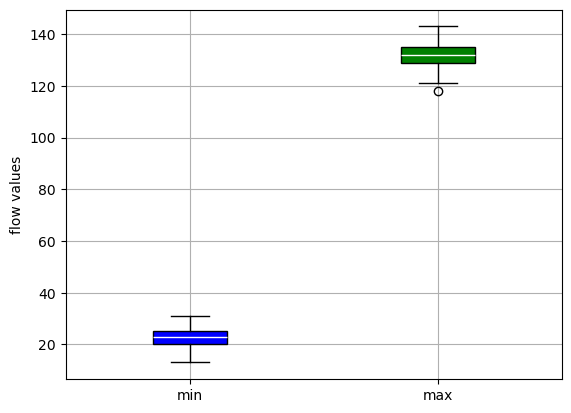

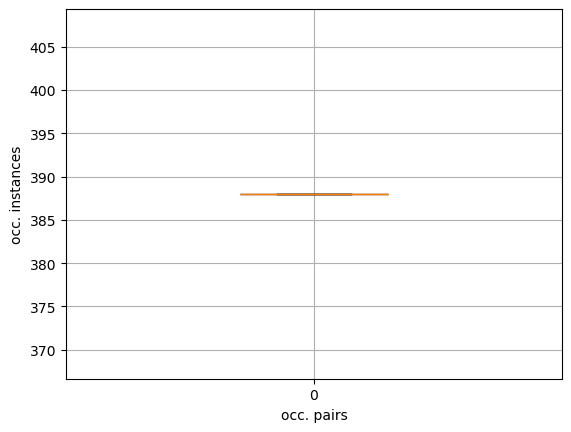

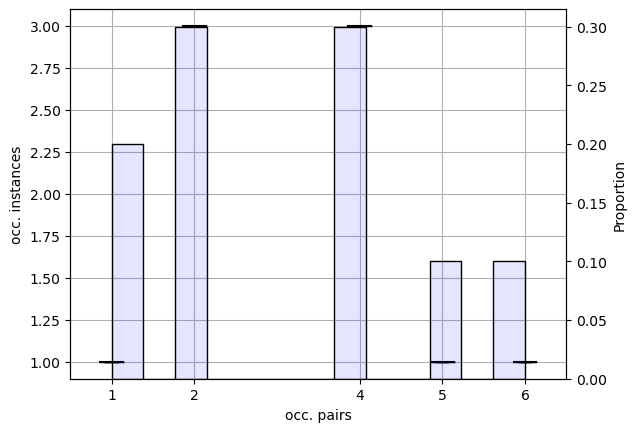

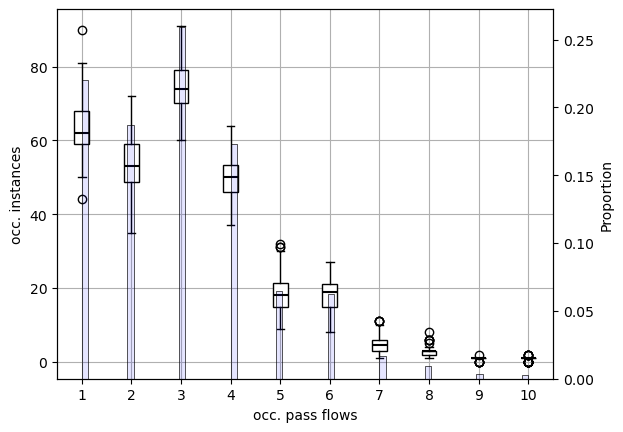

In [76]:
import os
import numpy as np
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')
from utils.graph_utils import get_arcs, out_degree, in_degree, get_neighbours
from utils.general_eval_msmd_metrics import instance_flow_proportion_shortest_paths


###########################################   Get the data   ################################################
dict_original_network = np.load("data/real_data/pre_processed/LieuSaint/real_instance_lieusaint.npy", 
                                allow_pickle = True).flatten()[0]

dict_instances_multi_flow = np.load("data/real_data/pre_processed/LieuSaint/data_instances.npy", 
                                    allow_pickle = True).flatten()[0]



###########################################   Capacities   ###############################
min_capacity = min(dict_original_network["capacities"][u][v] for u in dict_original_network["capacities"] for v in dict_original_network["capacities"][u])
max_capacity = max(dict_original_network["capacities"][u][v] for u in dict_original_network["capacities"] for v in dict_original_network["capacities"][u])
print("Min/Max capacity ", min_capacity, max_capacity)



###########################################   Mean proportion of arcs filled   ###############################
graph = dict_original_network["graph"]
nb_arcs_graph = len(get_arcs(graph))
nb_arcs_by_inst = [len(get_arcs(dict_instances_multi_flow[(num_instance, 
                                                          _, 
                                                          _)][0].adj_mat))
                                                                for num_instance, _, _ in dict_instances_multi_flow]
mean_nb_arcs_inst = sum(nb_arcs_by_inst)/len(nb_arcs_by_inst)
print("Mean proportion of arcs filled by the multi flow generation ", mean_nb_arcs_inst/nb_arcs_graph)



###########################################   Proportions of flow in shortest paths   ##########################
prop_shortest_paths_by_instance = []
for num_instance, _, _ in dict_instances_multi_flow:
    mfd_instance = dict_instances_multi_flow[(num_instance, _, _)][0]
    prop_shortest_paths = instance_flow_proportion_shortest_paths (graph,
                                                                   mfd_instance.original_aggregated_flow, 
                                                                   mfd_instance.ideal_transport_times, 
                                                                   mfd_instance.pairs)
    prop_shortest_paths_by_instance.append(prop_shortest_paths)
print("Mean/std proportion of flow in shortest paths ", np.mean(prop_shortest_paths_by_instance), 
                                                np.std(prop_shortest_paths_by_instance, ddof = 1))
print("Median proportion of flow in shortest paths ", np.median(prop_shortest_paths_by_instance))
bins = 'auto'
fig = plt.figure(figsize = (10, 6))
g = sns.histplot(prop_shortest_paths_by_instance,
                color = "blue", 
                edgecolor = 'black', 
                alpha = 0.5,
                stat = 'proportion',
                bins = bins)
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "distribution_prop_fl_sp_"), 
                             bbox_inches='tight', 
                             pad_inches = 0)"""

###########################################   Put all data in one data structure   ################################################
update_transport_time, update_transition_functions = True, True
ls_instances_processed = []
for ind_instance, upd_transport_time, upd_transition_function in dict_instances_multi_flow:
    if upd_transport_time == update_transport_time and upd_transition_function == update_transition_functions:
        # Fetch the mfd instance
        mfd_instance, original_multi_flow = dict_instances_multi_flow[(ind_instance, upd_transport_time, upd_transition_function)]
        ls_instances_processed.append((ind_instance, 
                                       mfd_instance, 
                                       original_multi_flow))
ls_instances_processed.sort(key = lambda x : x[0])


###########################################   Degrees/neighbours calculations   ####################################################
perfs_means_dict = [(id_inst,
                     [None for _ in range(len(ls_instances_processed[0][1].adj_mat))]) 
                            for id_inst in range(len(ls_instances_processed))]
for instance_infos in ls_instances_processed:
    num_instance, mfd_instance = instance_infos[0], instance_infos[1]
    nb_nodegree = 0
    for node in range(len(mfd_instance.adj_mat)):
        out_degree_node = out_degree(graph, node)
        if out_degree_node == 0:
            in_degree_node = in_degree(graph, node) 
            if in_degree_node == 0: nb_nodegree += 1
        nb_neighbours = len(get_neighbours(graph, node))
        perfs_means_dict[num_instance][1][node] = (node, out_degree_node, nb_neighbours)
    # print("Instance ", num_instance, nb_nodegree)


###########################################   Showing heatmap of neighbours   ##########################################
perfs_means_dict.sort(key = lambda x : -np.mean([e[1] for e in x[1]]))
for elem in perfs_means_dict: elem[1].sort(key = lambda x : -x[1])
perfs_means_map = [[perfs_means_dict[id_inst][1][v][1] for v in range(len(ls_instances_processed[0][1].adj_mat))]
                                                            for id_inst in range(len(ls_instances_processed))]
print("Size of heatmap ", len(perfs_means_map), len(perfs_means_map[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(perfs_means_map, 
                 annot=False, fmt=".3f", cmap="coolwarm",  
                 xticklabels=list(range(len(perfs_means_map[0]))), 
                 yticklabels=[e[0] for e in perfs_means_dict])
# Set axis labels
ax.set_xlabel("Nodes")
ax.set_ylabel("Instances")
ax.set_title("Heatmap representing the outdegrees of the nodes")


###########################################   Showing heatmap of outdegrees   #########################################
perfs_means_dict.sort(key = lambda x : -np.mean([e[2] for e in x[1]]))
for elem in perfs_means_dict: elem[1].sort(key = lambda x : -x[2])
perfs_means_map = [[perfs_means_dict[id_inst][1][v][2] for v in range(len(ls_instances_processed[0][1].adj_mat))]
                                                            for id_inst in range(len(ls_instances_processed))]
print("Size of heatmap ", len(perfs_means_map), len(perfs_means_map[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(perfs_means_map, 
                 annot=False, fmt=".3f", cmap="coolwarm",  
                 xticklabels=list(range(len(perfs_means_map[0]))), 
                 yticklabels=[e[0] for e in perfs_means_dict])
# Set axis labels
ax.set_xlabel("Nodes")
ax.set_ylabel("Instances")
ax.set_title("Heatmap representing the neighbours of the nodes")



###########################################   Ranges of flow values   #########################################
# Constructing a boxplot showing how the minimal and maximal flow values are spread
ls_min_fl_val = [min(mfd_instance.original_flow_values) 
                    for mfd_instance, _ in dict_instances_multi_flow.values()]
print("Minimal flow values range ", min(ls_min_fl_val), max(ls_min_fl_val))
ls_max_fl_val = [max(mfd_instance.original_flow_values) 
                    for mfd_instance, _ in dict_instances_multi_flow.values()]
print("Maximal flow values range ", min(ls_max_fl_val), max(ls_max_fl_val))

fig = plt.figure()
box = plt.boxplot(ls_min_fl_val, 
                  patch_artist = True,
                  widths = 0.3,
                  positions = [0])
box['boxes'][0].set_facecolor("blue")
box['medians'][0].set_color("white")

box = plt.boxplot(ls_max_fl_val, 
                  patch_artist = True,
                  widths = 0.3,
                  positions = [1])
box['boxes'][0].set_facecolor("green")
box['medians'][0].set_color("white")
plt.xticks([0, 1], ['min', 'max'])
plt.ylabel("flow values")
plt.grid(visible = True)
# Save the current figure
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "min_max_distributions"), 
                             bbox_inches='tight', 
                             pad_inches = 0)
"""



###########################################    Points of interest    #########################################
# Constructing a histogram showing how many nodes are point of interests 
# (sources or destinations)
nb_pairs = 15
nb_instances = len(set(id_instance for id_instance, _, _ in dict_instances_multi_flow))
cpt_node_nbpis = [[0 for _ in range(nb_pairs+1)] for _ in range(nb_instances)]
for id_instance, _, _ in dict_instances_multi_flow:
    mfd_instance, multi_flow = dict_instances_multi_flow[id_instance, True, True]
    nb_nodes = len(mfd_instance.original_adj_mat)
    for node in range(nb_nodes):
        nb_times_pis = len([1 for s, t in mfd_instance.pairs if node == s or node == t])
        cpt_node_nbpis[id_instance][nb_times_pis] += 1

bins = 'auto'
fig, ax = plt.subplots()
plt.boxplot([cpt_node_nbpis[id_instance][0] 
                           for id_instance in range(nb_instances)], 
            patch_artist = True,
            widths = 0.3,
            positions = [0])
plt.xlabel("occ. pairs")
plt.ylabel("occ. instances")
plt.grid(visible = True)

fig, ax1 = plt.subplots()
medians = []
for nb_times in range(1, nb_pairs+1):
    if any(cpt_node_nbpis[id_instance][nb_times] > 0 
                for id_instance in range(nb_instances)):
        data = [cpt_node_nbpis[id_instance][nb_times] for id_instance in range(nb_instances)]
        medians.append(np.median(data))
        box = ax1.boxplot([cpt_node_nbpis[id_instance][nb_times] 
                           for id_instance in range(nb_instances)], 
                          patch_artist = True,
                          widths = 0.3,
                          positions = [nb_times])
        box['boxes'][0].set_facecolor("white")
        box['medians'][0].set(color = "black",
                              linewidth = 1.5)
plt.xlabel("occ. pairs")
plt.ylabel("occ. instances")
plt.grid(visible = True)

# Histogram
#fig2 = plt.figure()
summed_cpt_node_nbpis = np.sum(cpt_node_nbpis, axis = 0)
for i in range(1, len(summed_cpt_node_nbpis)):
    data += [i]*summed_cpt_node_nbpis[i]
ax2 = ax1.twinx() 
cumulative = False
g = sns.histplot(data,   
            color = "blue", 
            edgecolor = 'black', 
            alpha = 0.1,
            stat = 'proportion',
            cumulative = cumulative,
            bins = bins,
            ax = ax2)
h, i = {}, 0
for rectangle in g.patches:
    height = rectangle.get_height()
    if height != 0: h[i] = round(height, 3)
    i += 1
print("Heights histogram nodes in pairs {num_bin:val,...} ")
print(h)

# Save the current figure
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "occ_node_pairs"), 
                             bbox_inches='tight', 
                             pad_inches = 0)
"""

# Constructing a histogram showing how many arc is traversed by how many flow
nb_pairs = 15
nb_instances = len(set(id_instance for id_instance, _, _ in dict_instances_multi_flow))
cpt_arc_pairs = [[0 for _ in range(nb_pairs+1)] for _ in range(nb_instances)]
for id_instance, _, _ in dict_instances_multi_flow:
    mfd_instance, multi_flow = dict_instances_multi_flow[id_instance, True, True]
    nb_nodes = len(mfd_instance.original_adj_mat)
    arcs = get_arcs(mfd_instance.original_adj_mat)
    for u, v in arcs:
        nb_pass_flows = sum(int(multi_flow[i][u][v] > 0) 
                                for i in range(len(multi_flow)))
        cpt_arc_pairs[id_instance][nb_pass_flows] += 1

bins = 'auto'
fig, ax1 = plt.subplots()
for nb_times in range(nb_pairs+1):
    if any(cpt_arc_pairs[id_instance][nb_times] > 0 
           for id_instance in range(nb_instances)):
        box = plt.boxplot([cpt_arc_pairs[id_instance][nb_times] 
                           for id_instance in range(nb_instances)], 
                          patch_artist = True,
                          widths = 0.3,
                          positions = [nb_times])
        box['boxes'][0].set_facecolor("white")
        box['medians'][0].set(color = "black",
                              linewidth = 1.5)
plt.grid(visible = True)
plt.xlabel("occ. pass flows")
plt.ylabel("occ. instances")
# Histogram
#fig2 = plt.figure()
summed_cpt_arc_pairs, data = np.sum(cpt_arc_pairs, axis = 0), []
for i in range(len(summed_cpt_arc_pairs)):
    data += [i]*summed_cpt_arc_pairs[i]
ax2 = ax1.twinx()
cumulative = False  
g = sns.histplot(data,   
            color = "blue", 
            edgecolor = 'black', 
            alpha = 0.1,
            cumulative = cumulative,
            stat = 'proportion',
            bins = bins,
            ax = ax2)
h, i = {}, 0
for rectangle in g.patches:
    height = rectangle.get_height()
    if height != 0: h[i] = round(height, 3)
    i += 1
print("Heights histogram flow passing through arcs {num_bin:val,...} ")
print(h)

# Save the current figure
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "occ_flow_arcs"), 
                             bbox_inches='tight', 
                             pad_inches = 0)
"""

plt.show()


Size of heatmap  100 57
Size of heatmap  57 15
Size of heatmap  57 15


Text(0.5, 1.0, 'The demand by pair over instances')

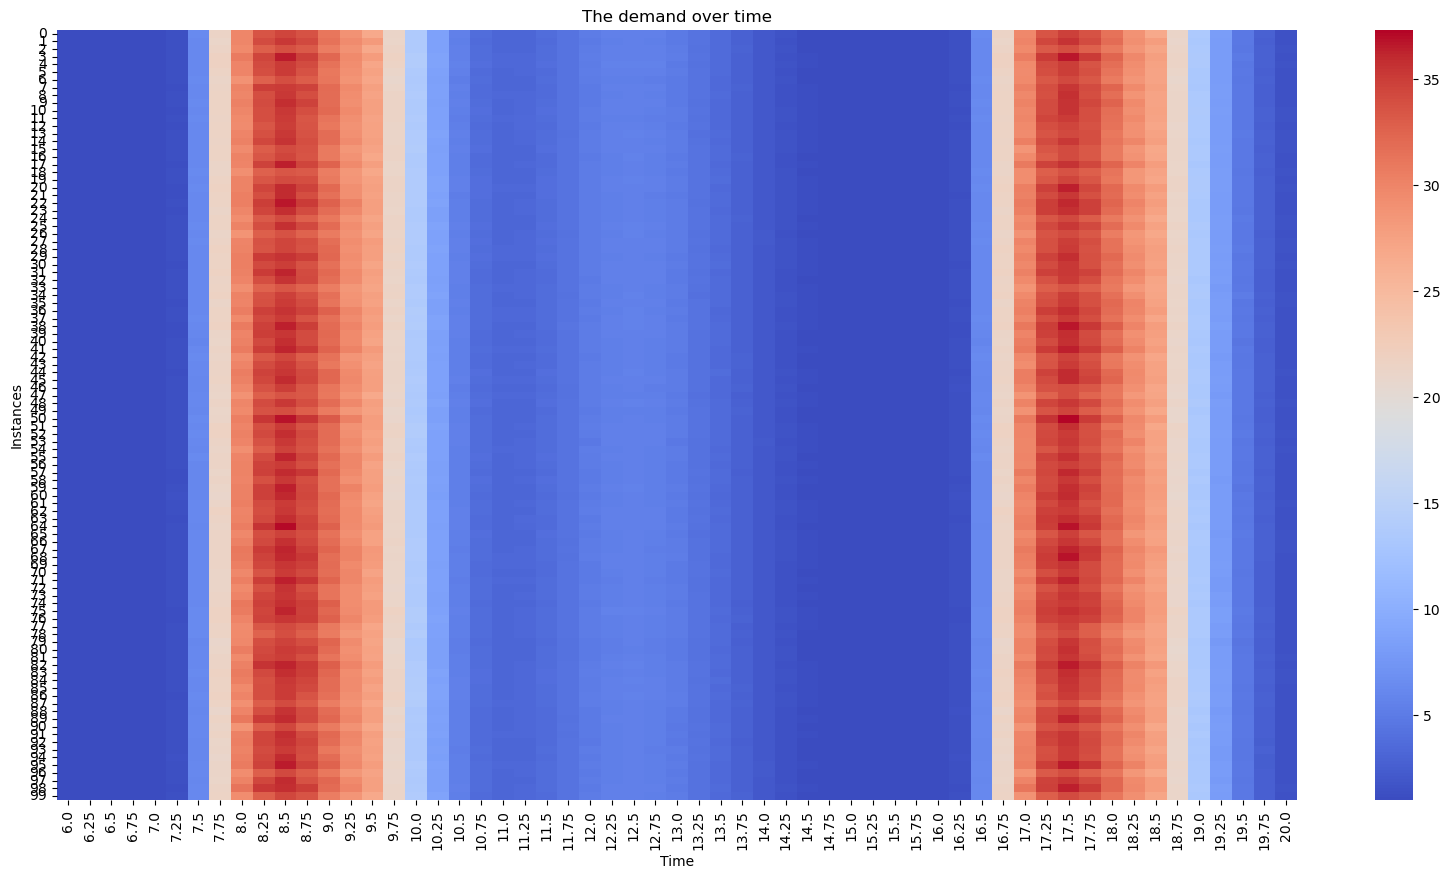

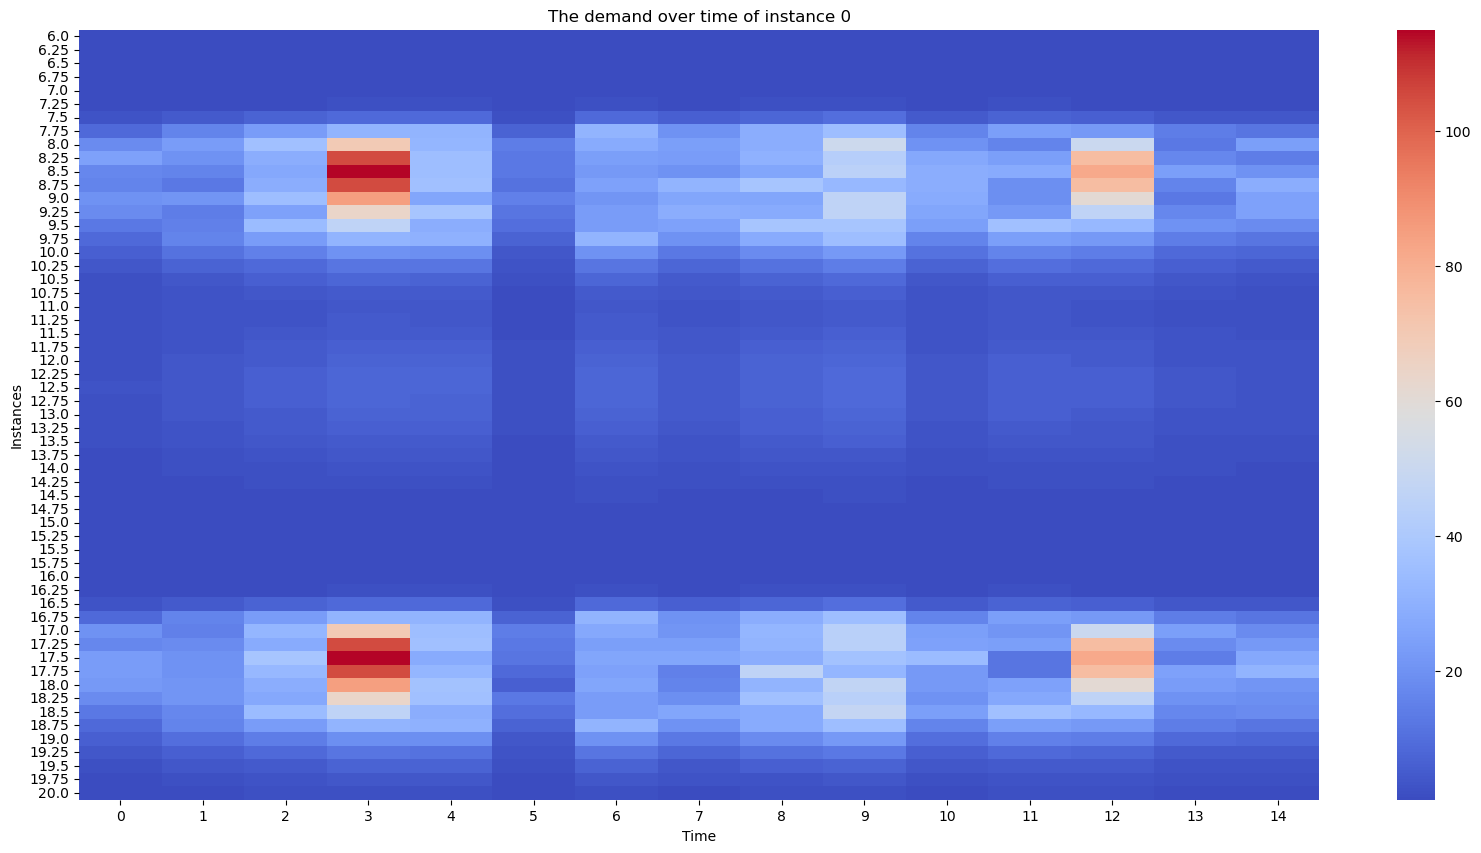

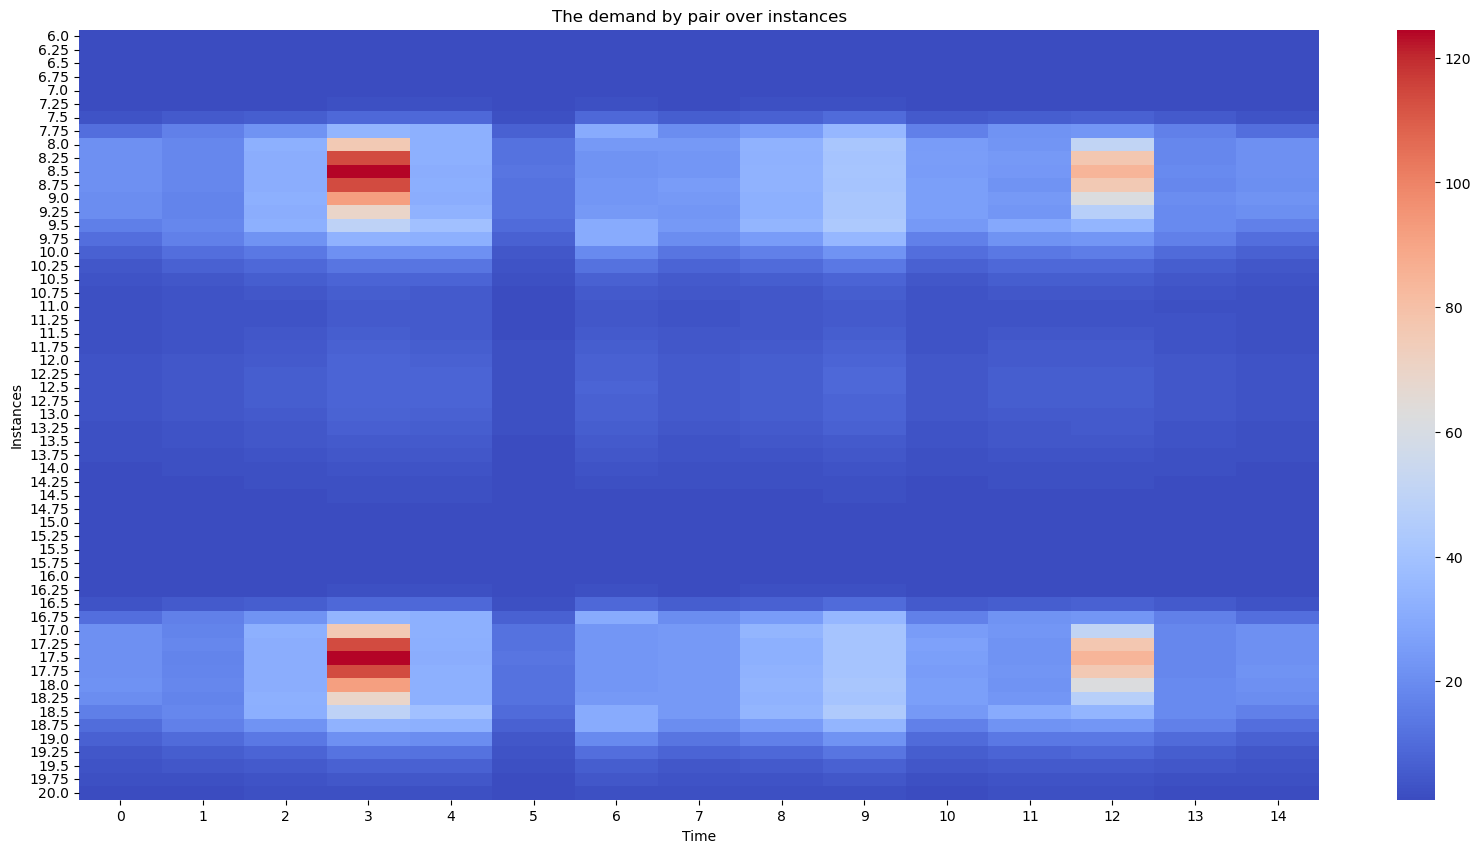

In [3]:
import os
import numpy as np
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')


dir_path_name = "data\data_simon\instances"
file_names = [f_name for f_name in os.listdir(dir_path_name) if os.path.isfile(os.path.join(dir_path_name, f_name)) and f_name[-4:] == ".npy"]
nb_instances, nb_pairs = 100, 15
dict_instances = {num_instance:{} for num_instance in range(nb_instances)}
for f_name in file_names:
    num_instance, time = int(f_name[:-4].split("_")[3]), float(f_name[:-4].split("_")[4])
    flow_values = np.load(os.path.join(dir_path_name, f_name), 
                          allow_pickle = True).flatten()[0]["flow_values"]
    dict_instances[num_instance][time] = flow_values


# Heatmap 1
list_times = sorted(list(dict_instances[num_instance].keys()), key = lambda x : float(x))
heatmap_data = [[sum(dict_instances[num_instance][time])/nb_pairs for time in list_times]
                                                                    for num_instance in dict_instances.keys()]
print("Size of heatmap ", len(heatmap_data), len(heatmap_data[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(heatmap_data, 
                annot=False, fmt=".3f", cmap="coolwarm",  
                xticklabels=sorted(list_times), 
                yticklabels=list(range(nb_instances)))
# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Instances")
ax.set_title("The demand over time")


# Heatmap 2
instance_num = 0
heatmap_data = [dict_instances[instance_num][time] for time in list_times]
print("Size of heatmap ", len(heatmap_data), len(heatmap_data[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(heatmap_data, 
                annot=False, fmt=".3f", cmap="coolwarm",  
                xticklabels=list(range(nb_pairs)), 
                yticklabels=list_times)
# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Instances")
ax.set_title("The demand over time of instance "+str(instance_num))


# Heatmap 3
heatmap_data = [np.median([dict_instances[instance_num][time] for instance_num in dict_instances],
                          axis = 0) for time in list_times]
print("Size of heatmap ", len(heatmap_data), len(heatmap_data[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(heatmap_data, 
                annot=False, fmt=".3f", cmap="coolwarm",  
                xticklabels=list(range(nb_pairs)), 
                yticklabels=list_times)
# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Instances")
ax.set_title("The demand by pair over instances")

No existant edges 
311 0


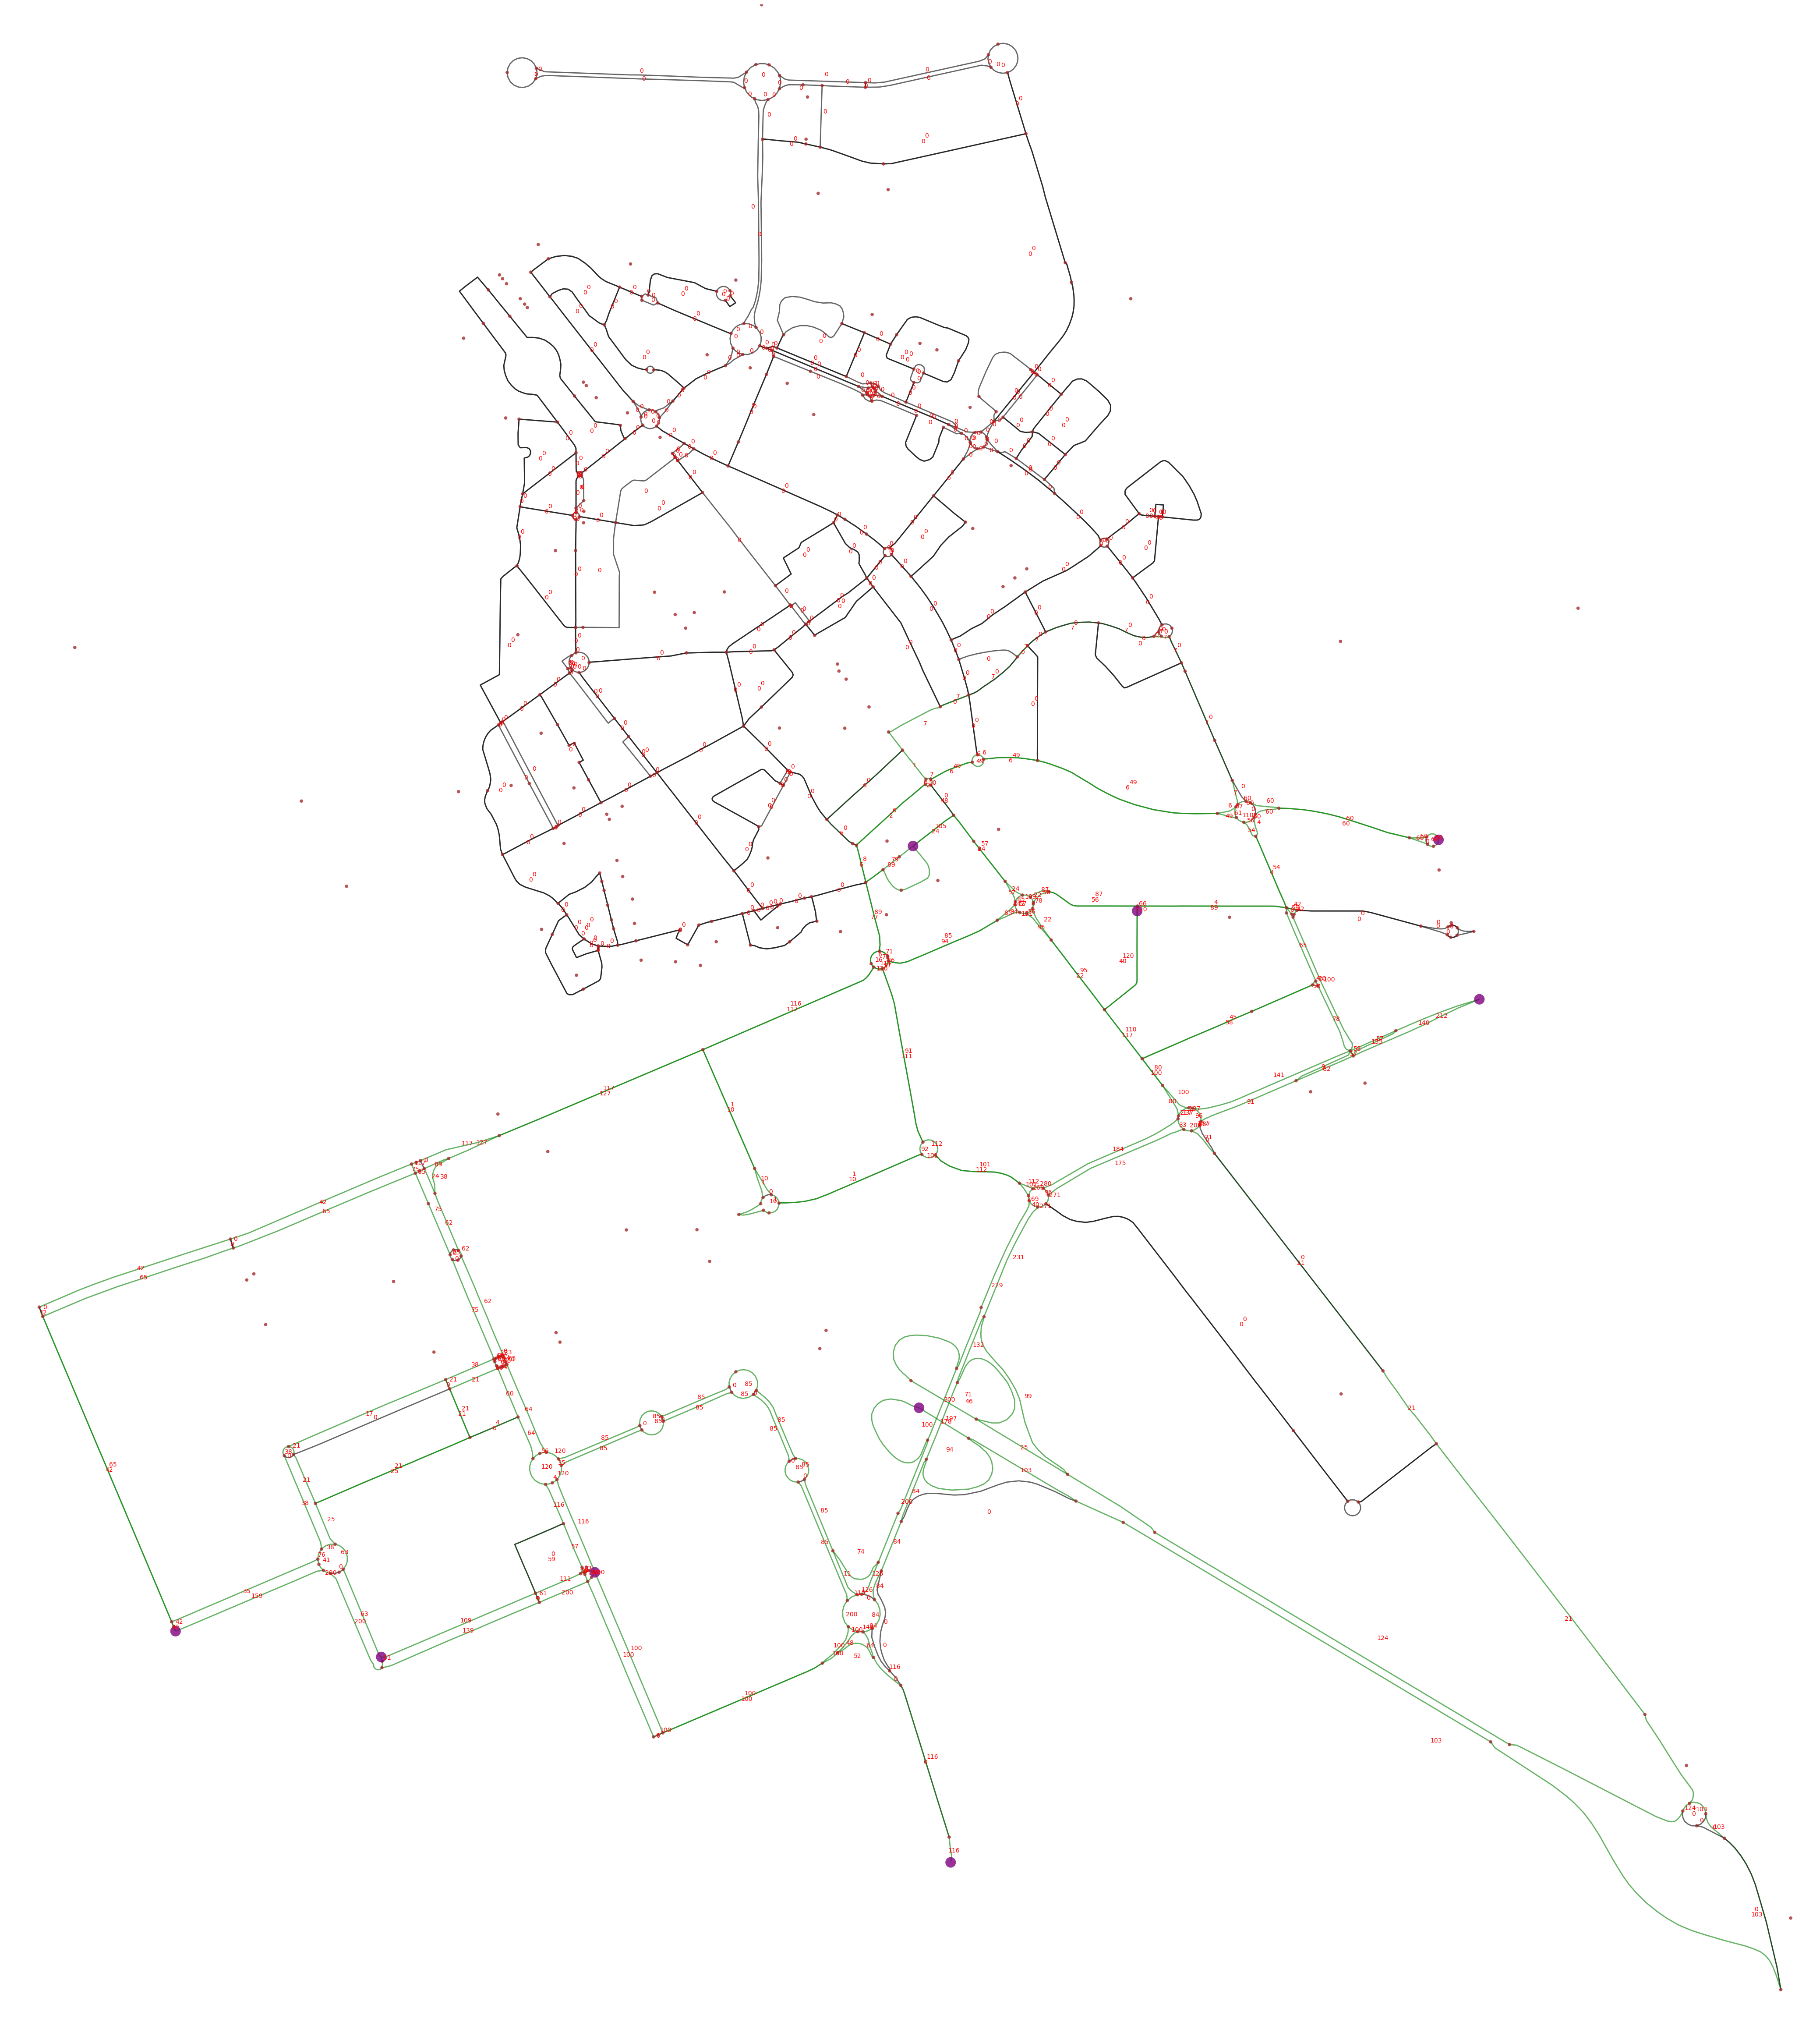

In [ ]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import os
import sys
sys.path.append(os.getcwd())
from utils.graph_utils import init_graph_arc_attribute_vals, get_arcs


with open("data/real_data/original_graphs/lieusaint.gpickle", 'rb') as f:
    original_nx_graph = pickle.load(f)
crs = original_nx_graph.graph['crs']
original_nx_nodes = list(original_nx_graph.nodes(data = True))


dict_original_network = np.load("data/real_data/pre_processed/LieuSaint/real_instance_lieusaint.npy", 
                                allow_pickle = True).flatten()[0]
graph = dict_original_network["graph"]
arcs = dict_original_network["arcs"]
node_list_nx = dict_original_network["nodes"]
arc_list_nx = [(node_list_nx[i], node_list_nx[j]) for i, j in dict_original_network["arcs"]]
geometries_nx = dict_original_network["geometries"]


dict_instance_multi_flow = np.load("data/real_data/pre_processed/LieuSaint/multi_flow_instances/multi_flow_instance_0.npy", 
                                   allow_pickle = True).flatten()[0]
multi_flow = dict_instance_multi_flow["multi_flow"]
interest_points_xy = set(node_list_nx[pair[0]] for pair in dict_instance_multi_flow["pairs"]) | set(node_list_nx[pair[1]] for pair in dict_instance_multi_flow["pairs"])
aggregated_flow = init_graph_arc_attribute_vals(graph)
for u, v in arcs: aggregated_flow[u][v] = sum(multi_flow[i][u].get(v, 0) for i in range(len(multi_flow)))



# Create the graph
sub_g = nx.MultiDiGraph()
sub_g.graph['crs'] = crs
sub_g.add_nodes_from(original_nx_nodes)
sub_g.add_edges_from([(u, v, {"geometry":geometries_nx[i],
                              "aggregated_flow":aggregated_flow.get(node_list_nx.index(u), {}).get(node_list_nx.index(v), 0)}) 
                                for i, (u, v) in enumerate(arc_list_nx)])


# Color the edges
flow_edge_list_nx = [(node_list_nx[i], node_list_nx[j]) for i, j in arcs if aggregated_flow[i].get(j, 0) > 0]
no_existant_edges = set()
for u, v in flow_edge_list_nx:
    if (u, v) not in {(e[0], e[1]) for e in arc_list_nx}:
       no_existant_edges.add((u, v))
print("No existant edges ")
print(len(flow_edge_list_nx), len(no_existant_edges)) 


edge_colors = []
for u, v, k, data in sub_g.edges(keys = True, data = True):
    if (u, v) in flow_edge_list_nx:
        edge_color = "green"
    else:
        edge_color = "black"
    edge_colors.append(edge_color)


node_colors, node_sizes = [], []
for node, data in sub_g.nodes(data = True):
    if node in interest_points_xy:
        node_color = "purple"
        node_size = 300
    else:
        node_color = "brown"
        node_size = 30
    node_colors.append(node_color)
    node_sizes.append(node_size)


fig, ax = ox.plot_graph(
    sub_g,
    figsize=(60, 60),
    node_color=node_colors,
    node_size=node_sizes,
    edge_color=edge_colors,
    edge_linewidth=2,
    edge_alpha=0.6,   # transparency (0 = fully transparent, 1 = opaque)
    node_alpha=0.8,
    bgcolor="white",
    show=False,
    close=False
)


for u, v, k, data in sub_g.edges(keys=True, data=True):
    x1, y1 = sub_g.nodes[u]["x"], sub_g.nodes[u]["y"]
    x2, y2 = sub_g.nodes[v]["x"], sub_g.nodes[v]["y"]

    add_ = 0.00005 if u > v else -0.00005

    # compute edge midpoint
    xm = ((x1 + x2) / 2) + add_
    ym = ((y1 + y2) / 2) + add_

    # Add label
    ax.text(xm, ym, str(sub_g[u][v][k]["aggregated_flow"]), fontsize=10, color="red")

plt.show()

In [79]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import os
import sys
import seaborn as sns
import numpy as np
import sys


dict_original_network = np.load("data/real_data/pre_processed/LieuSaint/real_instance_lieusaint.npy", 
                                allow_pickle = True).flatten()[0]
graph = dict_original_network["graph"]
arcs = dict_original_network["arcs"]
nb_arcs_graph = len(arcs)
print("Number of arcs ", nb_arcs_graph)
print("Number of arcs ", len(get_arcs(graph)))


dir_path_name = "data\data_simon\instances"
file_names = [f_name for f_name in os.listdir(dir_path_name) if os.path.isfile(os.path.join(dir_path_name, f_name)) and f_name[-4:] == ".npy"]
# time_line = np.linspace(start_time, end_time, (end_time - start_time) * 100 + 1)
dict_data = {}
for f_name in file_names:
    num_instance, time = int(f_name[:-4].split("_")[3]), float(f_name[:-4].split("_")[4])
    data = np.load(os.path.join(dir_path_name, f_name), 
                   allow_pickle = True).flatten()[0]
    multi_flow = data["multi_flow"]
    nb_arcs_flow, global_sum_flow_arcs = 0, 0
    for u, v in arcs:
        sum_flow = sum(multi_flow[i][u][v] for i in range(len(multi_flow)))
        if sum_flow > 0: 
            nb_arcs_flow += 1
            global_sum_flow_arcs += sum_flow
    
    prop_arcs_flow = nb_arcs_flow
    
    data_time = dict_data.get(time, [])
    data_time.append((prop_arcs_flow, global_sum_flow_arcs))
    dict_data[time] = data_time

bins = 'auto'
for time in sorted(dict_data.keys()):
    print("Nb arcs flow ", np.mean([e[0] for e in dict_data[time]]),
          " +/- ", np.std([e[0] for e in dict_data[time]], ddof = 1))
print("--------------------------------------------------")    
for time in sorted(dict_data.keys()):
    print("Sum flow arcs ", np.mean([e[1] for e in dict_data[time]]),
          " +/- ", np.std([e[1] for e in dict_data[time]], ddof = 1))

plt.show()

Number of arcs  806
Number of arcs  806
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0
Nb arcs flow  123.0  +/-  0.0


In [69]:
dict_original_network = np.load("data/real_data/pre_processed/LieuSaint/real_instance_lieusaint.npy", 
                                allow_pickle = True).flatten()[0]
graph = dict_original_network["graph"]
arcs = dict_original_network["arcs"]


dir_path_file = "data\data_simon\instances\multi_flow_instance_1_9.5.npy"
data = np.load(dir_path_file, allow_pickle = True).flatten()[0]

print(data["flow_values"])
aggregated_flow = init_graph_arc_attribute_vals(graph)
nb_arcs_flow = 0
for u, v in arcs:
    aggregated_flow[u][v] = sum(data["multi_flow"][i][u][v] for i in range(len(multi_flow)))
    if aggregated_flow[u][v] > 0:
        nb_arcs_flow += 1
print(nb_arcs_flow)

[14, 18, 34, 53, 44, 9, 38, 24, 34, 42, 24, 21, 31, 18, 18]
123
